In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jsonOps
import importlib
import handleData as hd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold


In [3]:
importlib.reload(jsonOps)

'''
operations to update all data:
step 1: run getData as python script. Will load every event from 2000-2022 from alldata into processedData. Long time.
step 2: run jsonOps.writeTeams(). Will write all specified data from year. currently default is 2 years, can set further back if want. Takes a while.
step 3: when you want data run loadTeams(). Pulls all data from jsons.

'''

#jsonOps.writeTeams(lyear=2018) #writes every game data for last 4 years, latest run was 4 years
 
#optional cell to flush grabbed data into jsons. Should only run if you know youve changed the data. (IE run getData with changed args)
#oftentimes when making edits to subfiles need to RESTART KERNEL MULTIPLE TIMES FOR CHANGES TO GO THROUGH!!!!!!!! 

In [5]:
importlib.reload(jsonOps)
allGamesDict = jsonOps.loadTeams()
keys = allGamesDict.keys()

<class 'dict'>


In [6]:

# count = 0
# alldelts = []
# size = len(allGamesDict)
# count = 0
# amountWanted = 1.1
# for key in keys:
#         ourGameID = key
#         theirGameID = allGamesDict[key][0][1][:3] + key[3:]
#         delts = hd.getGameDeltas(ourGameID, theirGameID, allGamesDict)
#         count += 1
#         if(not count % 10):
#             count = count
#         if(count/size > amountWanted):
#             break
#         if(delts == -1):
#             continue
#         alldelts.append(delts)
        
#         #in the future should only load from Jsondeltas instead of running whole bs
# print('done loading data now writing deltas')
# jsonOps.writeDeltas(alldelts)

alldelts = jsonOps.readDeltas()


done loading data now writing deltas


In [7]:
df = pd.DataFrame(alldelts, columns=['delavg', 'delobp', 'delslg', 'delruns', 'delrunsopposing', 'delwins', 'win'])
df.tail()
vals = hd.getTeam30DayNums('SDN202205020', allGamesDict)
val2 = hd.getTeam30DayNums('PIT202205020', allGamesDict)
sd = allGamesDict['SDN202205010']
pit = allGamesDict['PIT202205010']
print(vals.head())
df.tail()
#print(sd[0], pit[0])

         gameid       avg       obp       slg runs runsopposing win
0  SDN202205010  0.289474  0.314474  0.315789    5            2   1
1  SDN202204300  0.200000  0.276923  0.428571    6            6   0
2  SDN202204290  0.218750  0.423295  0.437500    7            3   1
3  SDN202204280  0.314286  0.469841  0.400000    7            5   1
4  SDN202204270  0.250000  0.425000  0.531250    8            5   1


,delavg,delobp,delslg,delruns,delrunsopposing,delwins,win
20235,0.009732,-0.004379,0.026753,0.774194,0.645161,0.032258,0
20236,0.000749,-0.014180,0.008194,0.387097,0.903226,0.000000,0
20237,-0.000809,-0.010467,0.013052,0.161290,-2.322581,0.387097,0
20238,0.003746,-0.012016,0.007750,0.193548,-2.096774,0.354839,0
20239,0.000872,-0.017693,0.006238,0.096774,-2.064516,0.322581,0


In [ ]:
# allGamesDict = jsonOps.loadTeams()
# alldelts = jsonOps.readDeltas()
# df = pd.DataFrame(alldelts, columns=['delavg', 'delobp', 'delslg', 'delruns', 'delrunsopposing', 'delwins', 'win'])


In [8]:
mdl = logit(formula = 'win ~ delavg + delobp + delslg + delruns + delrunsopposing + delwins', data=df).fit()
mdl.summary()

Optimization terminated successfully.
         Current function value: 0.675987
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                20240
Model:                          Logit   Df Residuals:                    20233
Method:                           MLE   Df Model:                            6
Date:                Sun, 11 Jun 2023   Pseudo R-squ.:                 0.02087
Time:                        22:01:58   Log-Likelihood:                -13682.
converged:                       True   LL-Null:                       -13974.
Covariance Type:            nonrobust   LLR p-value:                9.038e-123
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1529      0.014    -10.685      0.000      -0.181      -0.125
delavg             -6.5123      1.179     -5.522      0.000      -8.824      -4.201
delobp              5.2647      0.969      5.431      0.000       3.365       7.165
delslg              3.1575      0.621      5.088      0.000       1.941       4.374
delruns            -0.0244      0.036     -0.686      0.493      -0.094       0.045
delrunsopposing    -0.1726      0.021     -8.115      0.000      -0.214      -0.131
delwins             0.2359      0.173      1.363      0.173      -0.103       0.575
===================================================================================
"""

In [9]:
pred = mdl.predict(df)>.5
pred.astype(int)
vals = pd.crosstab(df['win'], pred.astype(int))
tn, fp, fn, tp = confusion_matrix(df['win'], pred).ravel() 
wrongMature = fn
rightMature = tp
wrongImmature = fp
rightImmature = tn
fracM = rightMature/(wrongMature + rightMature)
fracI = rightImmature/(wrongImmature + rightImmature)
print("sensitivity: percentage of games classified correctly as winning is " + str(fracM))
print("Specificity: percentage of games classified correctly as losing is " + str(fracI))
print("fraction total correctly classified", 
      (rightMature + rightImmature)/(rightMature+ wrongMature+rightImmature+wrongImmature),'\n')
vals

sensitivity: percentage of games classified correctly as winning is 0.4050160085378869
Specificity: percentage of games classified correctly as losing is 0.7238270469181233
fraction total correctly classified 0.5762351778656126 



col_0,0,1
win,,
0,7868,3002
1,5575,3795


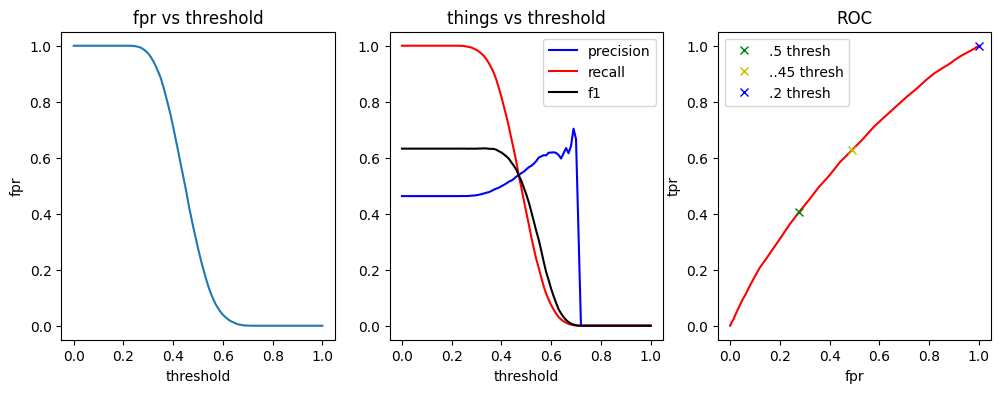

In [10]:
tvals = []
n=100
for i in range(0,n+1):
    tvals.append(1/n*i)

allfprs = []
allpres = []
allrecs = []
allf1s = []

values = mdl.predict(df)
for thresh in tvals:

    #create your predictored label using threshold value
    pred = values>thresh
    
    #ravel() is very useful, its unpacking the confusion matrix output
    #check out more https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
    tn, fp, fn, tp = confusion_matrix(df['win'], pred).ravel() 
    
    #calculate false positive rate, fpr, and also you should store it somewhere :)
    fpr = fp/(fp+tn)
    #for 4d, also calculate precision, recall and f1 score
    precision = tp/(tp+fp+.001)
    recall = tp/(tp+fn+.001)
    f1 = 2*(precision*recall)/(precision+recall+.001)
    allfprs.append(fpr)
    allpres.append(precision)
    allrecs.append(recall)
    allf1s.append(f1)
    if(thresh==.5):
        fpr5 = fpr
        tpr5 = recall
    if(thresh==.2):
        fpr2 = fpr
        tpr2 = recall
    if(thresh==.45):
        fpr45 = fpr
        tpr45 = recall

# plt.plot(tvals, allfprs, '.b')
# plt.xlabel('threshholds')
# plt.ylabel('fpr')
    
fig, axs = plt.subplots(1,3, figsize =(12,4))
axs[0].plot(tvals, allfprs, '')
axs[0].set_xlabel('threshold')
axs[0].set_ylabel('fpr')
axs[0].set_title('fpr vs threshold')

axs[1].plot(tvals, allpres, 'b', label='precision')
axs[1].plot(tvals, allrecs, 'r', label='recall')
axs[1].plot(tvals, allf1s, 'k', label='f1')

axs[1].set_xlabel('threshold')
axs[1].legend()
axs[1].set_title('things vs threshold')


axs[2].plot(allfprs,allrecs,'r')
axs[2].set_xlabel('fpr')
axs[2].set_ylabel('tpr')
axs[2].set_title('ROC')
axs[2].plot([fpr5], [tpr5], 'gx', label='.5 thresh')
axs[2].plot([fpr45], [tpr45], 'yx', label='..45 thresh')
axs[2].plot([fpr2], [tpr2], 'bx', label='.2 thresh')
axs[2].legend()

In [11]:
#some hints for question 5a,b
k = 10

#initialize two array to store your training and testing error
trainErr = np.zeros(k)
testErr = np.zeros(k)

In [23]:
#please leave the random_state variable unchanged, if you're interested in what it does, 
#you may read more here https://scikit-learn.org/stable/glossary.html#term-random_state
#this functio
kf = KFold(n_splits = k, random_state = 109, shuffle = True) 
errordf = pd.DataFrame({'trainerror':[], 'testerror':[]})
for trlInd,testInd in kf.split(df):
    #each it, select len/k index
    #save the rest to train
    testdf = df.iloc[testInd,]
    traindf = df.iloc[trlInd,]
    #fit model
    mdl = logit(formula = 'win ~ delavg + delobp + delslg + delruns + delrunsopposing + delwins', data=df).fit(disp=False)
    trainPred = mdl.predict(traindf)>.5
    testPred = mdl.predict(testdf)>.5
    tn, fp, fn, tp = confusion_matrix(traindf['win'], trainPred.astype(int)).ravel() 
    wrongMature = fn
    rightMature = tp
    wrongImmature = fp
    rightImmature = tn
    
    trainErr = 1-(rightMature + rightImmature)/(rightMature+ wrongMature+rightImmature+wrongImmature)
    
    tn, fp, fn, tp = confusion_matrix(testdf['win'], testPred.astype(int)).ravel() 
    wrongMature = fn
    rightMature = tp
    wrongImmature = fp
    rightImmature = tn
    testErr = 1-(rightMature + rightImmature)/(rightMature+ wrongMature+rightImmature+wrongImmature)
    curdf = pd.DataFrame({'trainerror':[trainErr], 'testerror':[testErr]})
    errordf = pd.concat([errordf,curdf], ignore_index=True)
    
errordf

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3039973035.py, line 4)

In [24]:
print('mean training error is ', errordf['trainerror'].mean())
print('training sem is ', errordf['trainerror'].sem())
print('mean test error is ', errordf['testerror'].mean())
print('test sem is ', errordf['testerror'].sem(),'\n')

mean training error is  0.4237648221343874
training sem is  0.0004417628845830072
mean test error is  0.4237648221343873
test sem is  0.003975865961247052 

